In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!wget https://bitbucket.org/ishaanjav/code-and-deploy-custom-tensorflow-lite-model/raw/a4febbfee178324b2083e322cdead7465d6fdf95/fruits.zip

--2025-01-27 11:24:06--  https://bitbucket.org/ishaanjav/code-and-deploy-custom-tensorflow-lite-model/raw/a4febbfee178324b2083e322cdead7465d6fdf95/fruits.zip
Resolving bitbucket.org (bitbucket.org)... 13.200.41.135, 13.200.41.134, 13.200.41.136, ...
Connecting to bitbucket.org (bitbucket.org)|13.200.41.135|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105946856 (101M) [application/zip]
Saving to: ‘fruits.zip’

fruits.zip          100%[===================>] 101.04M  17.1MB/s    in 6.7s    

2025-01-27 11:24:15 (15.1 MB/s) - ‘fruits.zip’ saved [105946856/105946856]



In [4]:
!unzip fruits.zip

Archive:  fruits.zip
replace __MACOSX/._fruits? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [6]:
tf.__version__

'2.17.1'

In [7]:
img_height, img_width = 32, 32
batch_size = 20

train_ds = tf.keras.utils.image_dataset_from_directory(
    "fruits/train",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    "fruits/validation",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    "fruits/test",
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 460 files belonging to 3 classes.
Found 66 files belonging to 3 classes.
Found 130 files belonging to 3 classes.


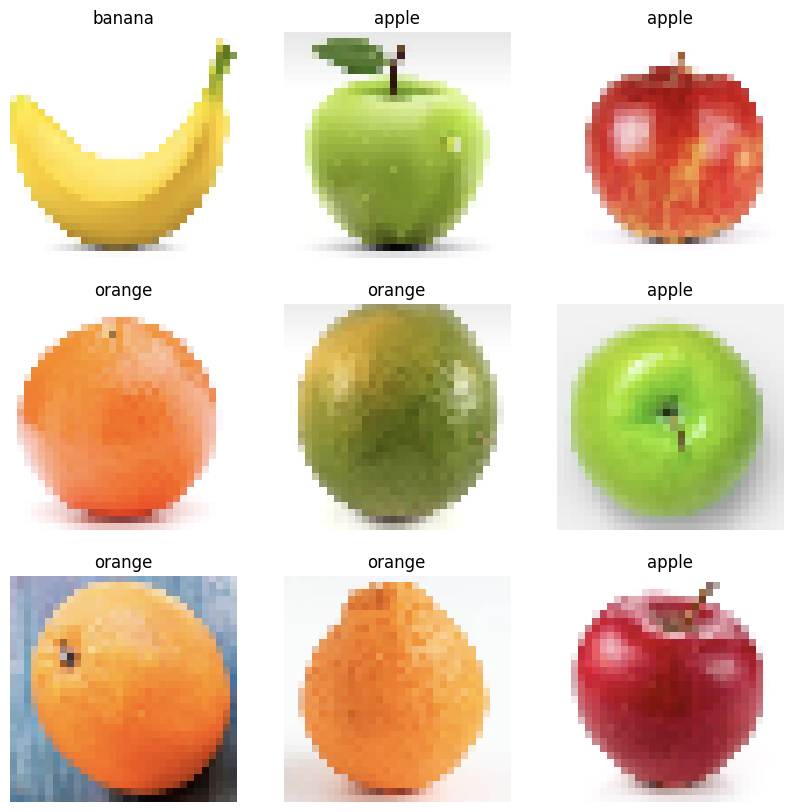

In [8]:
class_names = ["apple", "banana", "orange"]
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
model = tf.keras.Sequential(
    [
     tf.keras.layers.Rescaling(1./255),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(64, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(128, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(128, activation="softmax"),
     tf.keras.layers.Dense(3)
    ]
)

In [10]:
model.compile(
    optimizer="rmsprop",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics=['accuracy']
)

In [11]:
model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 20
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.3517 - loss: 1.0981 - val_accuracy: 0.3333 - val_loss: 1.0953
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.3657 - loss: 1.0905 - val_accuracy: 0.4242 - val_loss: 1.0519
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.5327 - loss: 1.0476 - val_accuracy: 0.4394 - val_loss: 1.0274
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.5935 - loss: 1.0026 - val_accuracy: 0.7576 - val_loss: 0.9726
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.6369 - loss: 0.9804 - val_accuracy: 0.6364 - val_loss: 0.9698
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.7301 - loss: 0.9477 - val_accuracy: 0.7121 - val_loss: 0.9311
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.8300 - loss: 0.9024 - val_accuracy: 0.7273 - val_loss: 0.9140
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.7612 - loss: 0.9085 - val_accuracy: 0.6667 

In [12]:
model.evaluate(test_ds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9467 - loss: 0.6042


[0.6106929183006287, 0.9461538195610046]

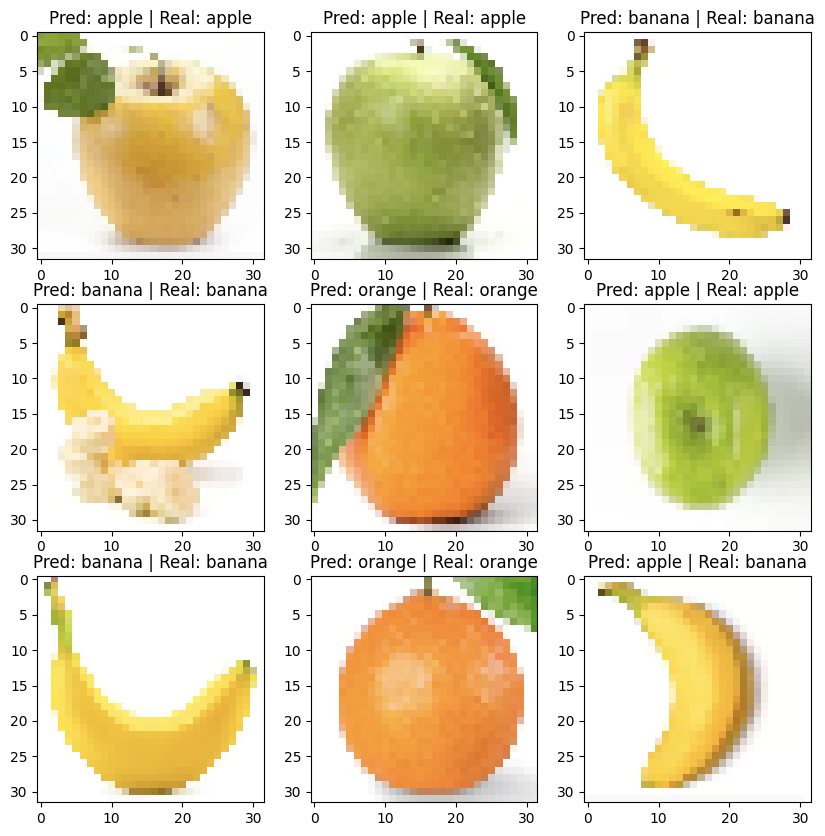

In [13]:
import numpy

plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
  classifications = model(images)
  # print(classifications)

  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = numpy.argmax(classifications[i])
    plt.title("Pred: " + class_names[index] + " | Real: " + class_names[labels[i]])

In [14]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmp7mo7klkf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132067191451920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132067191454800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132067191454992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132067191455568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132067159654672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132067159655632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132067159656016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132067159656976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132067159657360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132067159658320: TensorSpec(shape=(), dtype=tf.resource, name=None)
